# BERT Fine-Tuning Tutorial with PyTorch

By Chris McCormick and Nick Ryan

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [184]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [185]:
!pip install sentencepiece
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [186]:
import numpy as np
import pandas as pd

In [ ]:
#pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [187]:
traind = pd.read_csv("/content/drive/MyDrive/Cyber Bullying/CyberBulling_Dataset_Bangla.csv")
#vald = pd.read_csv("/content/drive/MyDrive/Softcom/Val.csv")
#testd = pd.read_csv("/content/drive/MyDrive/Softcom/Test.csv")

In [188]:
df = pd.read_csv("/content/drive/MyDrive/Cyber Bullying/CyberBulling_Dataset_Bangla.csv")
#vald = pd.read_csv("/content/drive/MyDrive/Softcom/Val.csv")
#testd = pd.read_csv("/content/drive/MyDrive/Softcom/Test.csv")

In [189]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

In [190]:

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
label_encoded = le.fit_transform(df['Label'])
label_encoded = label_encoded.reshape(-1, 1)
df_encoded = ohe.fit_transform(label_encoded)
df_encoded = pd.DataFrame(df_encoded.toarray(), columns=ohe.get_feature_names(['Label']))
df = pd.concat([df, df_encoded], axis=1)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [191]:
from sklearn.model_selection import train_test_split

# Splitting data into training and test sets
X = df.drop('Label', axis=1) # Features
y = df['Label'] # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Storing data in separate lists
train_list = [X_train, y_train]
val_list = [X_val, y_val]
test_list = [X_test, y_test]


In [192]:
#X_train, y_train = train_list
traind = pd.concat([X_train, y_train], axis=1)
vald= pd.concat([X_val, y_val], axis=1)
testd= pd.concat([X_test, y_test], axis=1)

In [193]:
print(len(testd))

1202


In [194]:
traind.head()

Unnamed: 0                                        Description  Label_0  \
4105        4105  কমেন্ট পড়তে আসলাম আমার মত যারা পড়তে আসছেন পিছন...      0.0   
5158        5158                                       অফ যান এইবার      1.0   
20            20  নারীর সৌন্দর্য যে নগ্নতায় নয় আবরনে, তা এখান থে...      0.0   
5417        5417                      নৌকার জয় সুনিশ্চিত ইনশাআল্লাহ      1.0   
1106        1106  তুমি একটা স্ক্যান্ডাল বানাই লিংক শেয়ার করো, তা...      0.0   

      Label_1  Label_2  Label_3  Label_4  Label  
4105      0.0      0.0      0.0      1.0      4  
5158      0.0      0.0      0.0      0.0      0  
20        0.0      0.0      1.0      0.0      3  
5417      0.0      0.0      0.0      0.0      0  
1106      0.0      0.0      1.0      0.0      3

#one-hot encoded labels and you want to convert them to label encoded format

In [195]:
print(np.unique(traind.Label))

[0 1 2 3 4]


In [196]:
print(np.unique(traind.Label))

[0 1 2 3 4]


In [197]:
traind.head()


Unnamed: 0                                        Description  Label_0  \
4105        4105  কমেন্ট পড়তে আসলাম আমার মত যারা পড়তে আসছেন পিছন...      0.0   
5158        5158                                       অফ যান এইবার      1.0   
20            20  নারীর সৌন্দর্য যে নগ্নতায় নয় আবরনে, তা এখান থে...      0.0   
5417        5417                      নৌকার জয় সুনিশ্চিত ইনশাআল্লাহ      1.0   
1106        1106  তুমি একটা স্ক্যান্ডাল বানাই লিংক শেয়ার করো, তা...      0.0   

      Label_1  Label_2  Label_3  Label_4  Label  
4105      0.0      0.0      0.0      1.0      4  
5158      0.0      0.0      0.0      0.0      0  
20        0.0      0.0      1.0      0.0      3  
5417      0.0      0.0      0.0      0.0      0  
1106      0.0      0.0      1.0      0.0      3

In [198]:
# Get the lists of sentences and their labels.
#emotions = [ "Love", "Joy", "Surprise", "Anger", "Sadness", "Fear"]
train_sentences = traind.Description.values
train_labels = traind['Label'].values
val_sentences = vald.Description.values
val_labels = vald['Label'].values
test_sentences = testd.Description.values
test_labels = testd['Label'].values

In [199]:
#train_labels = traind['label'].values
print(len(train_labels))

3606


In [200]:
print(f"Maximum Length of a phrase: {max(df.Description)}")
print(f"Minimum Length of a phrase: {min(df.Description)}")

Maximum Length of a phrase: ️কুত্তার বাচ্চার ফাসি চাই...
Minimum Length of a phrase: -তুমি কি কুত্তার পুটকি দিয়া বাইর অইছো?-না, অামি অামার মায়ের পেট থেকে বাইর অইছি।।- তুই কি অইটা দেখছোত? কুত্তার পুটকি দিয়াও তো বাইর অইতে পারতি।


# Graphical View

In [ ]:
# Calculate the Review of each of the Review
#df['Description'] = df.Post_cleaned.apply(lambda x:len(x.split()))

frequency = dict()
for i in df.Description:
    frequency[i] = frequency.get(i, 0)+1

sns.set(rc={'figure.figsize':(20, 7)})
plt.bar(frequency.keys(), frequency.values(), color ="r")
plt.xlim(1, 320)
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  

print(f"Maximum Length of a phrase: {max(df.Description)}")
print(f"Minimum Length of a phrase: {min(df.Description)}")
#print(f"Average Length of a phrase: {round(np.mean(df.Description), 0)}")

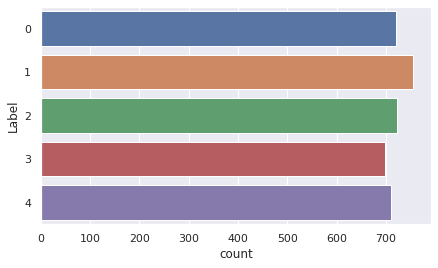

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(7, 4)})
promptsPlot = sns.countplot(y=traind['Label'], data=traind)
promptsPlot

In [203]:
testd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1202 entries, 79 to 4271
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1202 non-null   int64  
 1   Description  1202 non-null   object 
 2   Label_0      1202 non-null   float64
 3   Label_1      1202 non-null   float64
 4   Label_2      1202 non-null   float64
 5   Label_3      1202 non-null   float64
 6   Label_4      1202 non-null   float64
 7   Label        1202 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 84.5+ KB


# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

In [204]:
from transformers import BertTokenizer, AutoTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained('csebuetnlp/banglabert_generator')

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [205]:
# Print the original sentence.
print(' Original: ', train_sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences[0])))

 Original:  কমেন্ট পড়তে আসলাম আমার মত যারা পড়তে আসছেন পিছনে দাড়ান ঝামেলা করবেন না পড়তে দেন
Tokenized:  ['কমেন্ট', '[UNK]', 'আসলাম', 'আমার', 'মত', 'যারা', '[UNK]', 'আসছেন', 'পিছনে', '[UNK]', 'ঝামেলা', 'করবেন', 'না', '[UNK]', 'দেন']
Token IDs:  [8764, 1, 8191, 878, 1287, 1848, 1, 7358, 3960, 1, 6500, 2104, 795, 1, 1629]


In [206]:
max_len = 0

# For every sentence...
for sent in train_sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  847


In [207]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
train_input_ids = []
train_attention_masks = []
val_input_ids = []
val_attention_masks = []
test_input_ids = []
test_attention_masks = []
# For every sentence...
print("train_labels before for loop: ", train_labels)
for sent in train_sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )   
    train_input_ids.append(encoded_dict['input_ids'])
    train_attention_masks.append(encoded_dict['attention_mask'])
   # train_labels.append(train_label[i])
print("train_labels after for loop: ", train_labels)

# Convert the lists into tensors.
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.tensor(train_labels)
for sent in val_sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )   
    val_input_ids.append(encoded_dict['input_ids'])
    val_attention_masks.append(encoded_dict['attention_mask'])
val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
val_labels = torch.tensor(val_labels)
for sent in test_sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )   
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_sentences[0])
print('Token IDs:', test_input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


train_labels before for loop:  [4 0 3 ... 4 1 4]


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


train_labels after for loop:  [4 0 3 ... 4 1 4]
Original:  খানকির ছাওয়াল হিরো আলম খাইছি তোরে যাবি কই
Token IDs: tensor([    2,  1803,  4823,  9233,  5392, 11290,  3199,  3814,   871, 15845,
         8623,  2823,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [208]:
print("train_input_ids shape: ",train_input_ids.shape)
print("train_attention_masks shape: ",train_attention_masks.shape)
print("train_labels shape: ",train_labels.shape)

train_input_ids shape:  torch.Size([3606, 128])
train_attention_masks shape:  torch.Size([3606, 128])
train_labels shape:  torch.Size([3606])


## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [ ]:
#pip install -U scikit-learn scipy matplotlib

In [209]:
from torch.utils.data import TensorDataset, random_split
#from sklearn.model_selection import train_test_split

# Combine the training inputs into a TensorDataset.
# dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
# train_size = int(0.8 * len(dataset))
# rest_size = (len(dataset) - train_size)
# val_size = (len(dataset) - train_size)/2
# test_size = (len(dataset) - train_size)/2
# print(len(dataset))
# print('{:>5,} training samples'.format(train_size))
# print('{:>5,} validation samples'.format(val_size))
# print('{:>5,} test samples'.format(test_size))
# Divide the dataset by randomly selecting samples.

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)
# np.unique(y_train, return_counts=True)
# np.unique(y_val, return_counts=True)

# [train_I, rest_I,train_M, rest_M,train_L,rest_L]= train_test_split(input_ids.numpy(), attention_masks.numpy(), labels.numpy(), test_size=0.2,train_size=0.8, shuffle=True, stratify=labels.numpy())
# [val_I, test_I,val_M, test_M,val_L,test_L]= train_test_split(rest_I, rest_M, rest_L, test_size=0.5,train_size=0.5, shuffle=True, stratify=rest_L)


# print(test_input_ids)
# test_attention_masks
# test_labels

     
train_dataset=TensorDataset(torch.from_numpy(train_input_ids.numpy()),torch.from_numpy(train_attention_masks.numpy()),torch.from_numpy(train_labels.numpy()))
val_dataset=TensorDataset(torch.from_numpy(val_input_ids.numpy()),torch.from_numpy(val_attention_masks.numpy()),torch.from_numpy(val_labels.numpy()))
test_dataset=TensorDataset(torch.from_numpy(test_input_ids.numpy()),torch.from_numpy(test_attention_masks.numpy()),torch.from_numpy(test_labels.numpy()))

# train_dataset, rest_dataset = random_split(dataset, [int(train_size), int(rest_size)])
# val_dataset, test_dataset = random_split(rest_dataset, [int(val_size), int(test_size)])
train_dataset[0:5]

(tensor([[    2,  8764,     1,  8191,   878,  1287,  1848,     1,  7358,  3960,
              1,  6500,  2104,   795,     1,  1629,     3,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,   

In [210]:
print(train_input_ids.shape)
print(train_attention_masks.shape)
print(train_labels.shape)

torch.Size([3606, 128])
torch.Size([3606, 128])
torch.Size([3606])


In [211]:
print(train_input_ids.dtype)
print(train_attention_masks.dtype)
print(train_labels.dtype)
print(train_input_ids.shape)
print(train_attention_masks.shape)
print(train_labels.shape)
#Please ensure that all the three dataset have the same number of rows in them to avoid any dimensionality error.






torch.int64
torch.int64
torch.int64
torch.Size([3606, 128])
torch.Size([3606, 128])
torch.Size([3606])


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [212]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size =16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size,drop_last=True # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size,drop_last=True# Evaluate with this batch size.
        )
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size ,drop_last=True# Evaluate with this batch size.
        )

In [113]:
#!free -m

              total        used        free      shared  buff/cache   available
Mem:          12985        5858         570          13        6556        6828
Swap:             0           0           0


In [114]:
#!ps aux

USER         PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
root           1  0.0  0.0   1008     4 ?        Ss   18:52   0:00 /sbin/docker-
root           7  0.4  0.6 945788 83836 ?        Sl   18:52   0:22 /tools/node/b
root          17  0.0  0.0   6900  3124 ?        S    18:52   0:02 /bin/bash -e 
root          19  0.0  0.0   6900  1612 ?        S    18:52   0:00 /bin/bash -e 
root          21  0.7  0.2 788712 27892 ?        Sl   18:52   0:43 /usr/colab/bi
root          37  0.0  0.0   5520   508 ?        Ss   18:52   0:00 tail -n +0 -F
root          59  0.0  0.0      0     0 ?        Z    18:52   0:03 [python3] <de
root          60  0.0  0.3  82468 44508 ?        S    18:52   0:00 python3 /usr/
root          96  0.3  0.5 251720 73456 ?        Sl   18:52   0:21 /usr/bin/pyth
root          97  0.1  0.0 715824 10716 ?        Sl   18:52   0:05 /usr/local/bi
root        4293 44.3 38.1 30788484 5070256 ?    Ssl  19:10  32:55 /usr/bin/pyth
root        4332  0.2  0.1 612044 

#Model

In [213]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("CUDA is not available.")
    
# Check the current device being used by PyTorch
print("Current device:", torch.cuda.current_device())
print("Number of GPUs:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0))
print("Device properties:", torch.cuda.get_device_properties(0))



CUDA is available.
Current device: 0
Number of GPUs: 1
Device name: Tesla T4
Device properties: _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


#Memory problem hole

In [129]:
# clear GPU memory
#torch.cuda.empty_cache()

In [214]:
from transformers import ElectraForSequenceClassification, AdamW, BertConfig, AutoModel,AutoModelForPreTraining

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = ElectraForSequenceClassification.from_pretrained(
    "csebuetnlp/banglabert", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels =5, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
#model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Model is running on: {next(model.parameters()).device}")
CUDA_LAUNCH_BLOCKING=1 
model.to(device)

Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.out_proj.bias', 'classifi

Model is running on: cpu


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [215]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

electra.embeddings.word_embeddings.weight               (32000, 768)
electra.embeddings.position_embeddings.weight             (512, 768)
electra.embeddings.token_type_embeddings.weight             (2, 768)
electra.embeddings.LayerNorm.weight                           (768,)
electra.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

electra.encoder.layer.0.attention.self.query.weight       (768, 768)
electra.encoder.layer.0.attention.self.query.bias             (768,)
electra.encoder.layer.0.attention.self.key.weight         (768, 768)
electra.encoder.layer.0.attention.self.key.bias               (768,)
electra.encoder.layer.0.attention.self.value.weight       (768, 768)
electra.encoder.layer.0.attention.self.value.bias             (768,)
electra.encoder.layer.0.attention.output.dense.weight     (768, 768)
electra.encoder.layer.0.attention.output.dense.bias           (

In [216]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [240]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 15

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [241]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    print(pred_flat)
    print(labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [242]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [243]:
training_stats = []

In [169]:
pip install normalizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
for step, batch in enumerate(train_dataloader):

  print(batch[2].shape)


#training

In [245]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
# training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            #print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device) #16,16
        b_input_mask = batch[1].to(device)#16,16
        b_labels = batch[2].to(device)#16

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        #print(b_input_ids)
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        print(b_labels)

        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
        print(logits)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Streaming output truncated to the last 5000 lines.
        [-3.1786,  9.0238, -1.1242, -3.8518, -1.3206],
        [-3.6713, -2.8918,  9.6269, -2.4058, -0.9901],
        [-2.5368, -3.4586, -3.3319, -2.1264,  9.2818],
        [-2.3234, -2.9111, -2.9554, -2.9773,  9.2624],
        [-3.7862, -3.5814, -3.0135,  9.3198, -2.2173],
        [-3.7602, -2.8255, -3.4974,  9.0824, -2.2032],
        [ 8.6841, -3.6167, -2.7745, -3.9304, -1.4818],
        [-2.5037, -2.7773, -2.7454, -3.0207,  9.2492],
        [-3.0926, -3.1155, -4.4896,  7.8612, -0.4157],
        [-3.6382, -2.8736,  9.6446, -2.5854, -0.8683]], device='cuda:0')
[2 1 2 0 2 1 1 2 4 4 3 3 0 4 3 2]
[2 3 2 0 4 1 1 2 4 4 3 3 0 4 3 2]
tensor([0, 3, 4, 3, 4, 4, 2, 4, 1, 0, 2, 1, 3, 3, 4, 2], device='cuda:0')
tensor([[ 8.4433, -3.4580, -2.3656, -3.8788, -1.6554],
        [-3.7859, -2.6643, -3.8097,  9.0236, -1.9341],
        [-3.3439, -3.6868, -4.8122,  1.6412,  7.2455],
        [-3.5992, -3.6432, -3.1420,  9.2677, -2.1471],
        [ 8.4380, -

In [246]:
print(b_input_ids)

tensor([[    2, 29825,  1287,  ...,     0,     0,     0],
        [    2,  3877,   413,  ...,     0,     0,     0],
        [    2,   830,     1,  ...,     0,     0,     0],
        ...,
        [    2,  7974,  6205,  ...,     0,     0,     0],
        [    2,  5096,   919,  ...,     0,     0,     0],
        [    2,  1853,  2087,  ...,     0,     0,     0]], device='cuda:0')


In [247]:
#for epoch_i in range(0, epochs):
total_test_accuracy=0
logits_l=[]
y_true_l=[]

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
#model.test()

    # For each batch of training data...
for batch in test_dataloader:
        # Progress update every 40 batches.
 # if step % 5 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            
            # Report progress.
  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
  #model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
  result = model(b_input_ids, 
    token_type_ids=None, 
    attention_mask=b_input_mask, 
    labels=b_labels,
    return_dict=True)

  logits = result.logits


        # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  logits_l.extend(logits)
  y_true_l.extend(label_ids)
  

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
  # print(logits)
  # print(label_ids)

  total_test_accuracy += flat_accuracy(logits, label_ids)
  #classes_xy = np.argmax(logits, axis=1).flatten()
        

    # Report the final accuracy for this validation run.
avg_test_accuracy = total_test_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

  Batch   224  of    225.    Elapsed: 0:01:08.
[3 1 1 3 1 3 0 4 1 0 4 2 1 3 4 4]
[3 1 1 3 1 0 4 3 1 0 2 0 1 4 0 4]
  Batch   224  of    225.    Elapsed: 0:01:08.
[4 3 3 3 1 3 2 3 3 3 4 2 0 4 1 0]
[3 3 0 3 1 3 2 3 3 3 4 2 0 0 1 3]
  Batch   224  of    225.    Elapsed: 0:01:08.
[2 4 1 0 1 4 4 3 2 1 4 2 0 0 3 4]
[2 3 1 0 1 3 0 3 2 1 3 2 0 3 3 3]
  Batch   224  of    225.    Elapsed: 0:01:08.
[0 1 2 2 2 0 0 3 0 1 4 1 4 0 2 2]
[0 1 2 2 2 4 0 3 0 1 3 4 0 0 2 2]
  Batch   224  of    225.    Elapsed: 0:01:08.
[0 4 0 4 2 3 1 4 3 2 4 1 1 4 0 0]
[4 4 0 4 2 3 1 4 4 2 0 2 1 3 0 4]
  Batch   224  of    225.    Elapsed: 0:01:08.
[1 4 0 0 4 1 2 0 3 4 1 4 0 0 3 2]
[1 3 0 0 0 1 2 0 3 4 0 2 3 0 3 2]
  Batch   224  of    225.    Elapsed: 0:01:08.
[3 0 2 0 3 4 4 3 0 3 1 4 4 2 2 4]
[3 0 2 0 3 4 0 3 0 3 1 4 4 2 0 3]
  Batch   224  of    225.    Elapsed: 0:01:08.
[2 2 0 4 2 0 4 4 0 0 4 2 1 1 1 3]
[2 2 3 0 2 0 3 3 0 0 1 2 1 1 1 3]
  Batch   224  of    225.    Elapsed: 0:01:08.
[2 4 0 4 1 1 0 0 0 4 2 4 4 1 2 3]

#Let's view the summary of the training process.

In [248]:
import pandas as pd

# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1           0.057625     2.227518       0.732500       0:01:17         0:00:09
2           0.131980     1.805046       0.738333       0:01:16         0:00:09
3           0.062063     1.907622       0.747500       0:01:17         0:00:09
4           0.063794     2.028564       0.741667       0:01:16         0:00:09
5           0.045454     2.233722       0.744167       0:01:16         0:00:09
6           0.047511     1.991496       0.746667       0:01:17         0:00:09
7           0.023768     1.935337       0.760000       0:01:17         0:00:09
8           0.021047     2.089323       0.757500       0:01:16         0:00:09
9           0.011760     2.171717       0.749167       0:01:17         0:00:09
10          0.004540     2.214932       0.760833       0:01:16         0:00:09
11          0.008120     2.214639       0.756667       0:01:16         0:00:09
12          0.004313     2.181547       0.758333       0:01:16         0:00:09
13          0.003067     2.234960       0.757500       0:01:16         0:00:09
14          0.000957     2.224235       0.756667       0:01:16         0:00:09
15          0.000936     2.198278       0.758333       0:01:16         0:00:09

In [249]:
y_true=np.array(y_true_l)
classes_xy = np.argmax(logits_l, axis=1).flatten()

In [250]:
print(y_true)
print(classes_xy)

[3 1 1 ... 4 1 0]
[3 1 1 ... 4 1 0]


In [251]:
import platform
print(platform.python_version())


3.8.10


In [252]:
from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()
y_true_binary = binarizer.fit_transform(y_true)
classes_xy_binary = binarizer.fit_transform(classes_xy)


In [253]:
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.metrics import roc_auc_score
x=roc_auc_score(y_true_binary,classes_xy_binary)
print(x)

from sklearn.metrics import matthews_corrcoef
# y_true=np.argmax(test_labels,axis=1)
# classes_x=[-1 if item==0 else item for item in classes_xy]
# y_true=[-1 if item==0 else item for item in y_true]
mcc=matthews_corrcoef(y_true,classes_xy)
print(mcc)

# print(Counter(classes_x).keys()) # equals to list(set(words))
# print(Counter(classes_x).values())

from sklearn.metrics import confusion_matrix
conf=confusion_matrix(y_true, classes_xy)
print(conf[0][0])
print(conf[0][1])
print(conf[1][0])
print(conf[1][1])
cr=classification_report(y_true, classes_xy,digits=4,output_dict=True)
print(cr)

0.8570957168149157
0.7116985065457111
168
9
3
203
{'0': {'precision': 0.7368421052631579, 'recall': 0.702928870292887, 'f1-score': 0.7194860813704497, 'support': 239}, '1': {'precision': 0.8787878787878788, 'recall': 0.918552036199095, 'f1-score': 0.8982300884955752, 'support': 221}, '2': {'precision': 0.8969957081545065, 'recall': 0.8672199170124482, 'f1-score': 0.8818565400843882, 'support': 241}, '3': {'precision': 0.8064516129032258, 'recall': 0.6505576208178439, 'f1-score': 0.720164609053498, 'support': 269}, '4': {'precision': 0.570446735395189, 'recall': 0.7217391304347827, 'f1-score': 0.637236084452975, 'support': 230}, 'accuracy': 0.7675, 'macro avg': {'precision': 0.7779048081007914, 'recall': 0.7721995149514113, 'f1-score': 0.7713946806913772, 'support': 1200}, 'weighted avg': {'precision': 0.7788596525392609, 'recall': 0.7675, 'f1-score': 0.7694016903541435, 'support': 1200}}


In [254]:
training_stats_report=[]
training_stats_report.append(
        {
            'roc-auc': x,
            'mcc': mcc,
            'conf_0_0': conf[0][0],
            'conf_0_1': conf[0][1],
            'conf_1_0': conf[1][0],
            'conf_1_1': conf[1][1],
            'cr': cr
        }
    )

#training_stats_report


In [255]:
training_stats_report

[{'roc-auc': 0.8570957168149157,
  'mcc': 0.7116985065457111,
  'conf_0_0': 168,
  'conf_0_1': 9,
  'conf_1_0': 3,
  'conf_1_1': 203,
  'cr': {'0': {'precision': 0.7368421052631579,
    'recall': 0.702928870292887,
    'f1-score': 0.7194860813704497,
    'support': 239},
   '1': {'precision': 0.8787878787878788,
    'recall': 0.918552036199095,
    'f1-score': 0.8982300884955752,
    'support': 221},
   '2': {'precision': 0.8969957081545065,
    'recall': 0.8672199170124482,
    'f1-score': 0.8818565400843882,
    'support': 241},
   '3': {'precision': 0.8064516129032258,
    'recall': 0.6505576208178439,
    'f1-score': 0.720164609053498,
    'support': 269},
   '4': {'precision': 0.570446735395189,
    'recall': 0.7217391304347827,
    'f1-score': 0.637236084452975,
    'support': 230},
   'accuracy': 0.7675,
   'macro avg': {'precision': 0.7779048081007914,
    'recall': 0.7721995149514113,
    'f1-score': 0.7713946806913772,
    'support': 1200},
   'weighted avg': {'precision': 0.

#DID NOT Complile

In [ ]:
id=4
modelname="sagar"

In [ ]:
df = pd.DataFrame(training_stats_report) 
df2 = pd.DataFrame(training_stats) 
df3 = pd.DataFrame(logits)
df4 = pd.DataFrame(classes_xy,columns=['Pred'])
df4['True']=y_true
df5= pd.DataFrame(cr).transpose()
    
# saving the dataframe 
df.to_csv("C:/Users/MSI/Desktop/BFRD/Final/nlpaug/performance"+str(id)+str(modelname)+".csv") 
df2.to_csv("C:/Users/MSI/Desktop/BFRD/Final/nlpaug/history"+str(id)+str(modelname)+".csv") 
df3.to_csv("C:/Users/MSI/Desktop/BFRD/Final/nlpaug/probab"+str(id)+str(modelname)+".csv") 
df4.to_csv("C:/Users/MSI/Desktop/BFRD/Final/nlpaug/predict"+str(id)+str(modelname)+".csv") 
df5.to_csv("C:/Users/MSI/Desktop/BFRD/Final/nlpaug/cr"+str(id)+str(modelname)+".csv") 

FileNotFoundError: ignored

In [ ]:

# model.save("C:/Users/MSI/Desktop/BFRD/Final/nlpaug/model"+str(id)+str(modelname)+".h5")

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './'+modelname+str(id)+'model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))
